# Reproducing LMRv2.1 with cfr

In [1]:
%load_ext autoreload
%autoreload 2

import cfr
import numpy as np
print(cfr.__version__)

octave not found, please see README
2024.11.6


## Load Data

### Load proxies

In [2]:
job = cfr.ReconJob()
job.load_proxydb(
    path='./prev_data/updated_pages2kv2.json', 
    verbose=True,
    pid_column='pid', 
    lat_column='lat',  
    lon_column='lon',  
    elev_column = 'elev',
    time_column = 'time',
    value_column = 'value',
    ptype_column = 'ptype'

)

#fig, ax = job.proxydb.plot(plot_count=True)


>>> job.configs["proxydb_path"] = ./prev_data/updated_pages2kv2.json
>>> 544 records loaded
>>> job.proxydb created


In [3]:
tester = job.proxydb.to_df()
tester.head()

,pid,lat,lon,elev,ptype,time,value
0,Ocn_148,43.6561,290.1983,-30.0,bivalve.d18O,"[1033.0, 1034.0, 1035.0, 1036.0, 1037.0, 1038....","[1.1400000000000001, 1.06, 0.8, 0.690000000000..."
1,Ocn_170,-21.8333,114.1833,-6.0,coral.calc,"[1900.0, 1901.0, 1902.0, 1903.0, 1904.0, 1905....","[-29.80451, 10.97039, 28.05434, 21.96584, -2.7..."
2,Ocn_174,-21.9,113.9667,-6.0,coral.calc,"[1900.0, 1901.0, 1902.0, 1903.0, 1904.0, 1905....","[10.975999999999999, -4.3906600000000005, -3.3..."
3,Ocn_073,20.83,273.26,-3.1,coral.calc,"[1773.0, 1774.0, 1775.0, 1776.0, 1777.0, 1778....","[-0.6050091019, 0.11922153810000001, -0.967124..."
4,Ocn_173,-17.5167,118.9667,-6.0,coral.calc,"[1900.0, 1901.0, 1902.0, 1903.0, 1904.0, 1905....","[-3.65572, 15.4608, 6.62304, -20.1302, 14.6722..."


### Load model prior (CMIP5 CCSM4 last1000 simulated tas and pr fields)

In [4]:
job.load_clim(
    tag='prior',
    
    path_dict= {
    'tas': './prev_data/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc',
    'pr': './prev_data/ccsm4_last_millenium/pr_sfc_Amon_CCSM4_past1000_085001-185012.nc'
    },
    anom_period=[850,1850],  # Tardif 2019 uses entire interval
    load=True,  
    verbose=True,
)

>>> job.configs["prior_path"] = {'tas': './prev_data/ccsm4_last_millenium/tas_sfc_Amon_CCSM4_past1000_085001-185012.nc', 'pr': './prev_data/ccsm4_last_millenium/pr_sfc_Amon_CCSM4_past1000_085001-185012.nc'}
>>> job.configs["prior_anom_period"] = [850, 1850]
>>> job.configs["prior_lat_name"] = lat
>>> job.configs["prior_lon_name"] = lon
>>> job.configs["prior_time_name"] = time
>>> The time axis does not overlap with the reference period [850, 1850]; use its own time period as reference [.2f, .2f].
>>> The time axis does not overlap with the reference period [850, 1850]; use its own time period as reference [.2f, .2f].
>>> prior variables ['tas', 'pr'] loaded
>>> job.prior created


In [5]:
# Check after load
print("\nAfter initial load:")
print("Shape:", job.prior['tas'].da.shape)
print("Contains NaN?", np.any(np.isnan(job.prior['tas'].da.values)))
if not np.any(np.isnan(job.prior['tas'].da.values)):
    print("Sample values from first timestep:")
    vals = job.prior['tas'].da.isel(time=0, lat=slice(0,5), lon=slice(0,5)).values
    print(vals)


After initial load:
Shape: (12012, 192, 288)
Contains NaN? False
Sample values from first timestep:
[[ 4.2724609e-04 -1.4116669e+00 -1.4149780e+00 -7.6078796e-01
  -1.3295441e+00]
 [ 2.8004456e-01  2.4789429e-01  3.3767700e-01 -5.2047729e-02
   3.3233643e-01]
 [ 4.6669006e-01 -1.6618347e-01  5.8181763e-01 -2.5801086e-01
   2.7944946e-01]
 [ 3.3268738e-01  3.2659912e-01  3.8771057e-01  4.2834473e-01
   6.8528748e-01]
 [ 3.4626770e-01  3.5942078e-01  6.5942383e-01  1.0366669e+00
   7.7363586e-01]]


### Load instrumental observations

In [6]:
job.load_clim(
    tag='obs',
    path_dict={
        'pr': './prev_data/GPCC_precip.mon.flux.1x1.v6.nc',
        'tas': 'gistemp1200_ERSSTv4'
    },
    rename_dict={'pr': 'precip','tas': 'tempanomaly'},
    anom_period=[1951, 1980], 
    load=True,
    verbose = True
)

>>> job.configs["obs_path"] = {'pr': './prev_data/GPCC_precip.mon.flux.1x1.v6.nc', 'tas': 'gistemp1200_ERSSTv4'}
>>> job.configs["obs_rename_dict"] = {'pr': 'precip', 'tas': 'tempanomaly'}
>>> job.configs["obs_anom_period"] = [1951, 1980]
>>> job.configs["obs_lat_name"] = lat
>>> job.configs["obs_lon_name"] = lon
>>> job.configs["obs_time_name"] = time
>>> The target file seems existed at: ./data/gistemp1200_ERSSTv4.nc.gz . Loading from it instead of downloading ...
>>> obs variables ['pr', 'tas'] loaded
>>> job.obs created


## Calibrate PSM

In [7]:
# PSM to be used
ptype_psm_dict = {
    'tree.TRW': 'Bilinear',
    'tree.MXD': 'Linear',
    'coral.d18O': 'Linear',
    'coral.SrCa': 'Linear',
    'ice.d18O': 'Linear',
    'ice.dD': 'Linear',
    'lake.varve_thickness': 'Linear',
}

# target variables
ptype_clim_dict = {
    'tree.TRW': ['tas', 'pr'],
    'tree.MXD': ['tas'],
    'coral.d18O': ['tas'],
    'coral.SrCa': ['tas'],
    'ice.d18O': ['tas'],
    'ice.dD': ['tas'],
    'lake.varve_thickness': ['tas'],
}

# Seasonality for each proxy type
ptype_season_dict = {
    'tree.TRW': [  # expert curated pool of possible growing seasons
        [1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'tree.MXD': [  # expert curated pool of possible growing seasons
        #[1,2,3,4,5,6,7,8,9,10,11,12],
        [6,7,8],
        [3,4,5,6,7,8],
        [6,7,8,9,10,11],
        [-12,1,2],
        [-9,-10,-11,-12,1,2],
        [-12,1,2,3,4,5],
    ],
    'coral.d18O': list(range(1, 13)),            # annual
    'coral.SrCa': list(range(1, 13)),            # annual
    'ice.d18O': list(range(1, 13)),              # annual
    'ice.dD': list(range(1,13)),
    'lake.varve_thickness': list(range(1, 13)),  # annual
}

In [8]:
job.calib_psms(
    ptype_psm_dict=ptype_psm_dict,
    ptype_season_dict=ptype_season_dict,
    ptype_clim_dict=ptype_clim_dict,
    nobs_lb = 25,
    verbose=True,
)

>>> job.configs["ptype_psm_dict"] = {'bivalve.d18O': 'Linear', 'lake.accumulation': 'Linear', 'lake.varve_thickness': 'Linear', 'coral.d18O': 'Linear', 'ice.dD': 'Linear', 'ice.melt': 'Linear', 'coral.SrCa': 'Linear', 'lake.varve_property': 'Linear', 'tree.d18O': 'Linear', 'tree.TRW': 'Bilinear', 'tree.MXD': 'Linear', 'coral.calc': 'Linear', 'ice.d18O': 'Linear'}
>>> job.configs["ptype_season_dict"] = {'bivalve.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'lake.accumulation': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'lake.varve_thickness': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'ice.dD': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'ice.melt': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'coral.SrCa': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'lake.varve_property': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'tree.d18O': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], 'tree.TRW': [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12], [6, 7, 8], [3, 4, 5, 6, 

Calibrating the PSMs:  12%|█▏        | 65/544 [00:02<00:17, 27.77it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  23%|██▎       | 125/544 [00:04<00:15, 26.37it/s]

The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  25%|██▍       | 134/544 [00:05<00:14, 27.52it/s]

The number of overlapped data points is 0 < 25. Skipping ...
The number of overlapped data points is 0 < 25. Skipping ...


Calibrating the PSMs:  28%|██▊       | 155/544 [00:33<10:26,  1.61s/it]

Asi_119 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_119 >>> Nearest climate is NaN. Searching around within distance of 2 deg ...
Asi_119 >>> Found nearest climate within distance of 2 deg.


Calibrating the PSMs:  42%|████▏     | 231/544 [02:41<08:36,  1.65s/it]

Asi_118 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_118 >>> Found nearest climate within distance of 1 deg.


Calibrating the PSMs:  57%|█████▋    | 310/544 [04:54<06:23,  1.64s/it]

Asi_111 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_111 >>> Found nearest climate within distance of 1 deg.


Calibrating the PSMs:  80%|███████▉  | 433/544 [08:19<03:02,  1.64s/it]

Asi_117 >>> Nearest climate is NaN. Searching around within distance of 1 deg ...
Asi_117 >>> Found nearest climate within distance of 1 deg.


Calibrating the PSMs: 100%|██████████| 544/544 [09:59<00:00,  1.10s/it]

>>> PSM for Ocn_138 failed to be calibrated.
>>> PSM for Ant_023 failed to be calibrated.
>>> PSM for Arc_026 failed to be calibrated.
>>> PSM for Arc_014 failed to be calibrated.
>>> 540 records tagged "calibrated" with ProxyRecord.psm created


### Run PSMs

In [9]:
job.forward_psms(verbose=True)

>>> job.configs["ptype_forward_dict"] = {}


Forwarding the PSMs: 100%|██████████| 540/540 [02:33<00:00,  3.52it/s]

>>> ProxyRecord.pseudo created for 540 records


### Annualize and Regrid model prior fields

In [10]:

job.annualize_clim(tag='prior', verbose=True, months=list(range(1, 13)))
job.regrid_clim(tag='prior', nlat=42, nlon=63, verbose=True)

>>> job.configs["prior_annualize_months"] = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
>>> Processing tas ...
>>> Processing pr ...
>>> job.prior updated
>>> job.configs["prior_regrid_nlat"] = 42
>>> job.configs["prior_regrid_nlon"] = 63
>>> Processing tas ...
>>> Processing pr ...


### (Optional) Save the job object for later reload

In [11]:
job.save('./cases/lmr_reproduce_pda_v3', verbose=True)

>>> job.configs["save_dirpath"] = ./cases/lmr_reproduce_pda_v3
>>> prior_tas saved to: ./cases/lmr_reproduce_pda_v3/prior_tas.nc
>>> prior_pr saved to: ./cases/lmr_reproduce_pda_v3/prior_pr.nc
>>> obs_pr saved to: ./cases/lmr_reproduce_pda_v3/obs_pr.nc
>>> obs_tas saved to: ./cases/lmr_reproduce_pda_v3/obs_tas.nc
>>> job saved to: ./cases/lmr_reproduce_pda_v3/job.pkl


## Run DA solver

In [12]:
job.run_da_mc(
    save_dirpath='./recons/lmr_reproduce_pda_v3',
    recon_seeds=list(range(1, 2)),  # as an example here
    recon_vars=['tas','pr'],  # running tas and pr even though paper mainly focuses on tas
    recon_period=[1, 2000],
    verbose=True,
)

>>> job.configs["recon_period"] = [1, 2000]
>>> job.configs["recon_loc_rad"] = 25000
>>> job.configs["recon_timescale"] = 1
>>> job.configs["recon_vars"] = ['tas', 'pr']
>>> job.configs["nens"] = 100
>>> job.configs["recon_seeds"] = [1]
>>> job.configs["assim_frac"] = 0.75
>>> job.configs["save_dirpath"] = ./recons/lmr_reproduce_pda_v3
>>> job.configs["compress_params"] = {'zlib': True}
>>> job.configs["output_full_ens"] = False
>>> job.configs["recon_sampling_mode"] = fixed
>>> job.configs["trim_prior"] = True
>>> job.configs["allownan"] = False
>>> seed: 1 | max: 1


KF updating: 100%|██████████| 2000/2000 [20:10<00:00,  1.65it/s]


>>> Reconstructed fields saved to: ./recons/lmr_reproduce_pda_v3/job_r01_recon.nc
>>> DONE! Total time spent: 22.32 mins.


In [13]:
res = cfr.ReconRes('./recons/lmr_reproduce_pda_v3/')

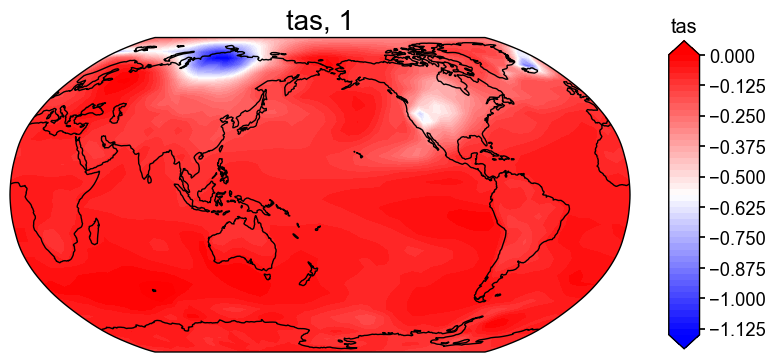

In [14]:
res.load(['tas', 'tas_gm', 'pr', 'pr_gm'])

# Create a basic plot
if 'tas' in res.recons:
    fig, ax = res.recons['tas'].plot(cmap='bwr')

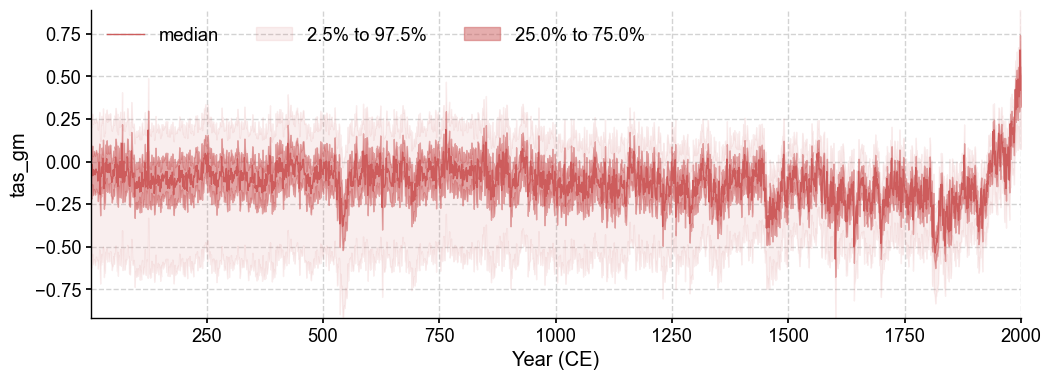

In [15]:
# Plot with ensemble spread
fig, ax = res.recons['tas_gm'].plot_qs()

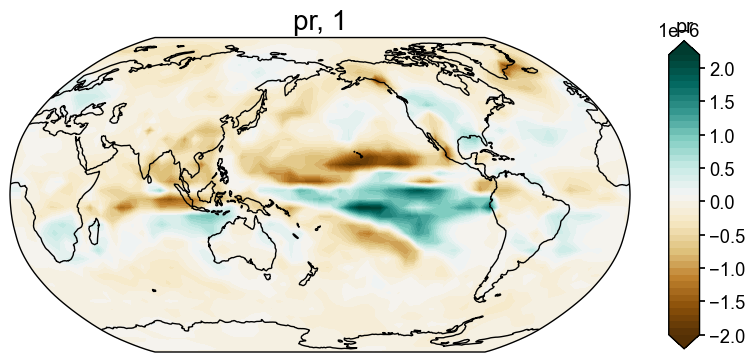

In [16]:
fig, ax = res.recons['pr'].plot()

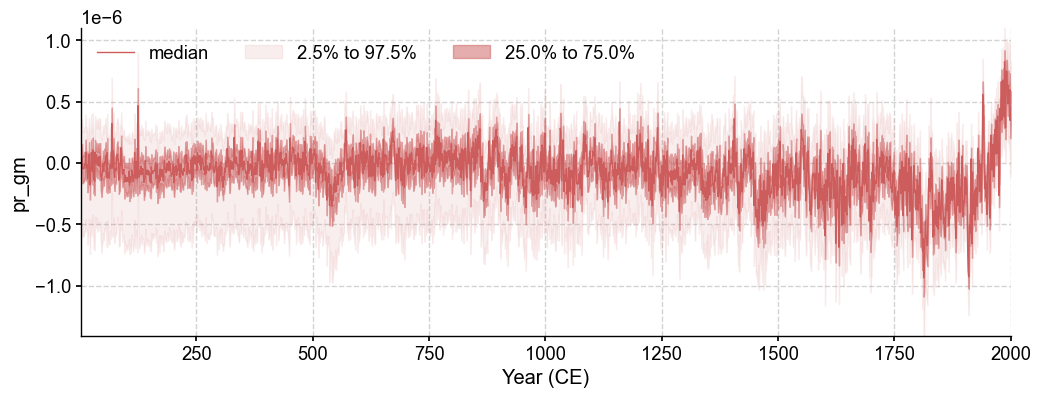

In [17]:
fig, ax = res.recons['pr_gm'].plot_qs()